<a href="https://colab.research.google.com/github/andres-merino/AprendizajeAutomaticoInicial-05-N0105/blob/main/2-Ejercicios/03-Agrupamiento-Jerarquico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="border: none; border-collapse: collapse;">
    <tr>
        <td style="width: 20%; vertical-align: middle; padding-right: 10px;">
            <img src="https://i.imgur.com/nt7hloA.png" width="100">
        </td>
        <td style="width: 2px; text-align: center;">
            <font color="#0030A1" size="7">|</font><br>
            <font color="#0030A1" size="7">|</font>
        </td>
        <td>
            <p style="font-variant: small-caps;"><font color="#0030A1" size="5">
                <b>Facultad de Ciencias Exactas, Naturales y Ambientales</b>
            </font> </p>
            <p style="font-variant: small-caps;"><font color="#0030A1" size="4">
                Aprendizaje Automático Inicial &bull; Agrupamiento Jerarquico
            </font></p>
            <p style="font-style: oblique;"><font color="#0030A1" size="3">
                Emilio Andrade &bull; 12/14/2025
            </font></p>
        </td>  
    </tr>
</table>

---
## <font color='264CC7'> Introducción </font>

A lo largo de este taller, aplicaremos el algoritmo de agrupamiento jerárquico a un conjunto de datos.

Los paquetes necesarios son:

In [48]:
# Paquetes mínimos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


---
## <font color='264CC7'> Preprocesamiento de datos </font>

Primero necesitas el conjunto de datos. Los datos a utilzar son los seleccionados en la clase aterior.

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Carga el conjunto de datos y procésalos:
<ul>
  <li>Muestra algunos datos.</li>
  <li>Muestra una descripción de los datos.</li>
  <li>Escala los datos si es necesario.</li>
</ul>
</div>

In [49]:
# Paso 1: Cargar, quitar outlier (Chansey) y escalar


data = pd.read_csv(
    "https://raw.githubusercontent.com/andres-merino/AprendizajeAutomaticoInicial-05-N0105/refs/heads/main/2-Notebooks/datos/Pokemon.csv"
)

# Quitamos Chansey porque es un caso muy atípico en estas variables
data = data[data["Name"] != "Chansey"].reset_index(drop=True)

display(data.head())
display(data.describe())

numeric_cols = ["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"]
X = data[numeric_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Dimensiones (sin Chansey):", X_scaled.shape)



,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Stage,Remaining_Evolutions,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,2,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,2,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,3,0,False
3,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,2,False
4,5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80,2,1,False


,#,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Stage,Remaining_Evolutions
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,75.753333,406.793333,62.973333,73.000000,68.646667,67.353333,65.760000,69.060000,1.586667,0.573333
std,43.775041,100.015790,24.283269,26.101248,26.502156,28.507655,24.066652,26.791321,0.677408,0.678991
min,1.000000,195.000000,10.000000,10.000000,15.000000,15.000000,20.000000,15.000000,1.000000,0.000000
25%,38.250000,320.000000,45.000000,52.000000,50.000000,45.000000,48.500000,45.750000,1.000000,0.000000
50%,75.500000,405.000000,60.000000,70.000000,65.000000,65.000000,65.000000,70.000000,1.000000,0.000000
75%,113.500000,490.000000,79.750000,90.000000,84.500000,88.750000,80.000000,90.000000,2.000000,1.000000
max,151.000000,680.000000,160.000000,134.000000,180.000000,154.000000,125.000000,140.000000,3.000000,2.000000


Dimensiones (sin Chansey): (150, 6)


En el preprocesamiento se eliminó **Chansey** porque actúa como un **valor atípico extremo** en las variables usadas para el agrupamiento (principalmente por su **HP muy alto** en comparación con el resto). Mantenerlo generaba un clúster de un solo elemento y podía distorsionar la interpretación de los grupos. Tras la eliminación, el conjunto queda con **150 observaciones**, dejando los datos más representativos para el análisis de clustering.


---
## <font color='264CC7'> Dendograma </font>

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Genera el dendograma de los datos.
<ul>
  <li>Usa diferentes métricas y funciones de enlace.</li>
  <li>Toma una distancia de corte.</li>
  <li>De manera intutiva, ¿por qué tomaste la métrica y la distancia de corte?</li>
</ul>
</div>

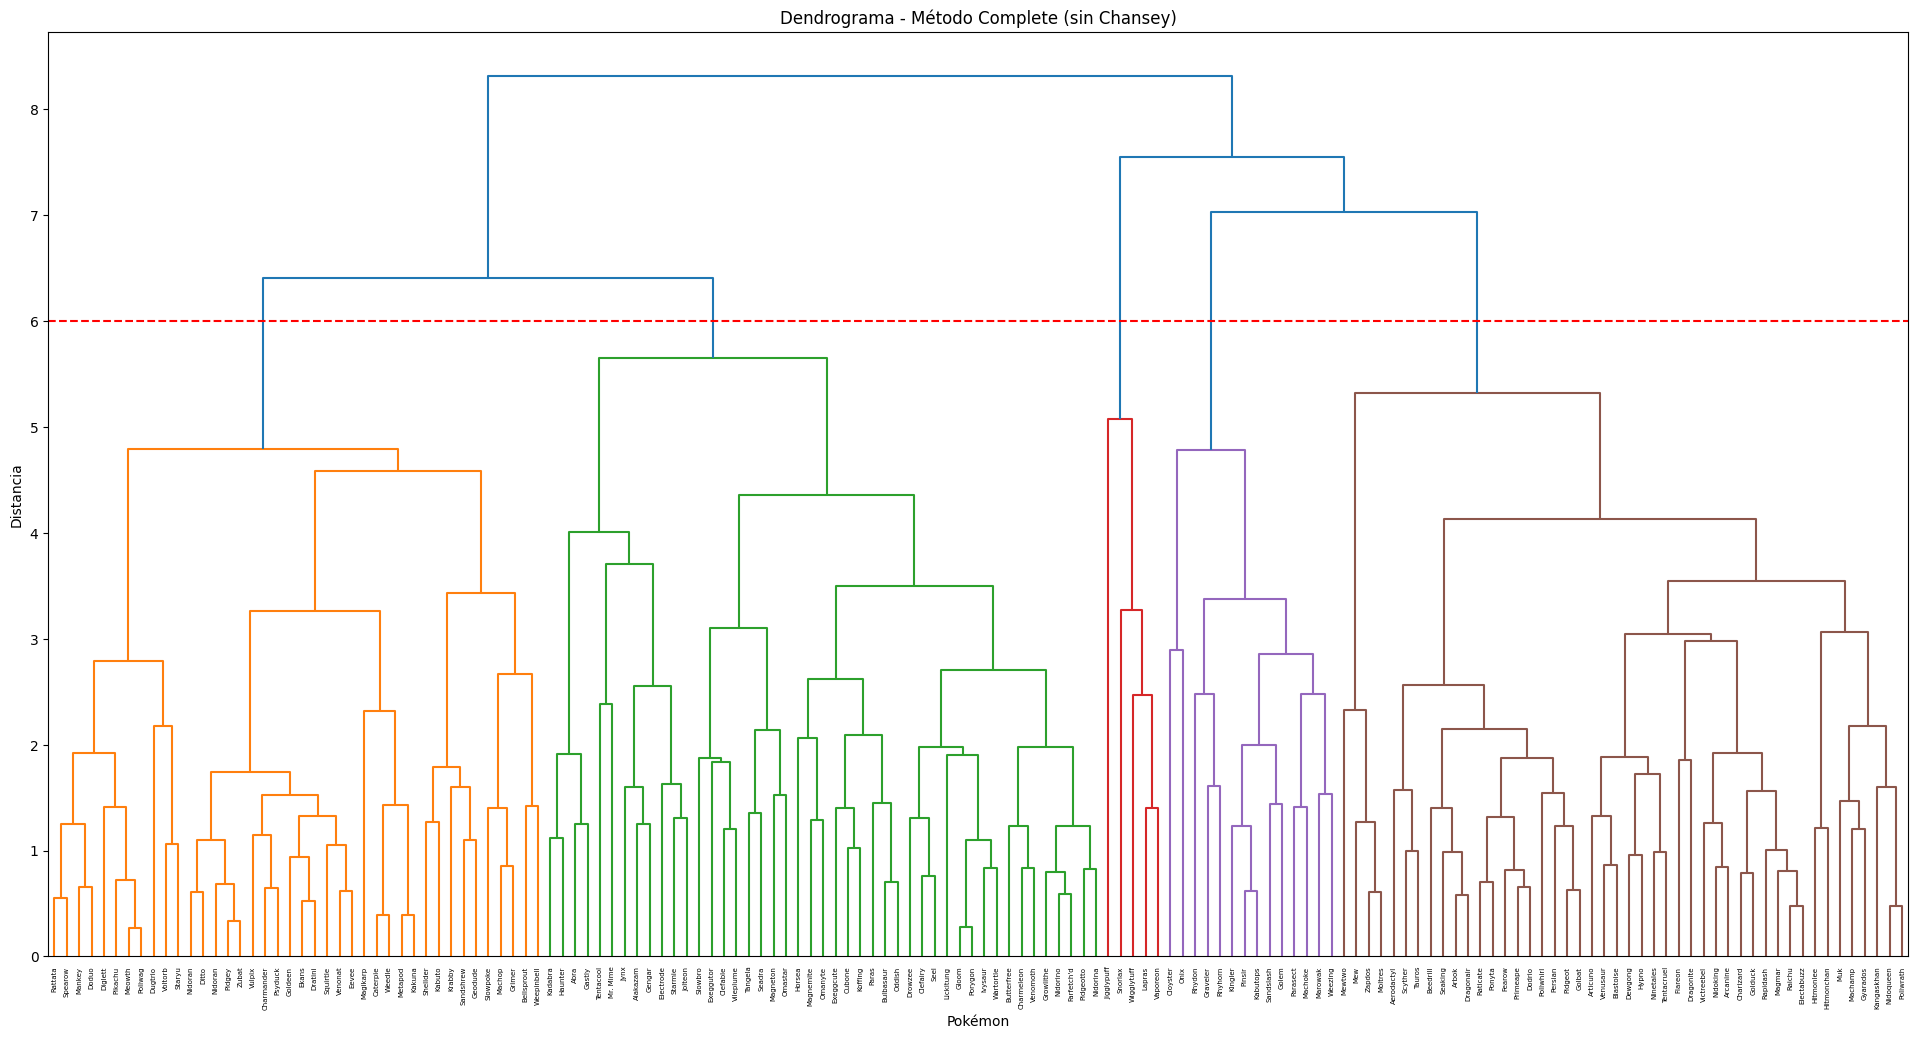

In [50]:
# Paso 2: Dendrograma con distancia de corte


Z = linkage(X_scaled, method="complete", metric="euclidean")

distancia_corte = 6

plt.figure(figsize=(24, 12))
dendrogram(Z, labels=data["Name"].values)
plt.axhline(y=distancia_corte, color="red", linestyle="--")
plt.title("Dendrograma - Método Complete (sin Chansey)")
plt.xlabel("Pokémon")
plt.ylabel("Distancia")
plt.show()



Usé el **método de enlace complete** con **distancia euclidiana** porque estamos comparando variables numéricas (HP, Attack, Defense, Sp. Atk, Sp. Def y Speed) y, al estar **escaladas**, la euclidiana mide de forma coherente la similitud entre Pokémon.

Elegí la **distancia de corte = 6** de manera intuitiva porque en el dendrograma (sin Chansey) se observa una separación clara entre varias ramas principales alrededor de ese valor. Cortar en 6 permite formar grupos distinguibles antes de que se unan clústeres grandes, evitando tanto mezclar perfiles muy diferentes como dividir en exceso.


---
## <font color='264CC7'> Asignación de grupos y análisis </font>


<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Realiza un análisis de los grupos obtenidos.
<ul>
  <li>Asigna los grupos.</li>
  <li>Revisa la media de cada grupo.</li>
  <li>Revisa el mínimo y máximo de cada grupo.</li>
  <li>Muestra algunos integrantes de cada grupo.</li>
</ul>
</div>

In [51]:
# Paso 3: Asignación de grupos y análisis

# 1) Asignar los grupos usando la distancia de corte
data['Cluster'] = fcluster(Z, t=distancia_corte, criterion='distance')

# 2) Media de cada grupo
print("Media por grupo:")
display(data.groupby('Cluster')[numeric_cols].mean())

# 3) Mínimo y máximo de cada grupo
print("Mínimo y máximo por grupo:")
display(data.groupby('Cluster')[numeric_cols].agg(['min', 'max']))

# 4) Mostrar algunos integrantes de cada grupo
for c in sorted(data['Cluster'].unique()):
    print(f"\nGrupo {c}:")
    display(data[data['Cluster'] == c][['Name'] + numeric_cols].head())


Media por grupo:


,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
Cluster,,,,,,
1,43.650000,57.300000,51.000000,41.100000,41.800000,57.950000
2,57.066667,56.111111,66.222222,84.244444,68.266667,65.711111
3,135.000000,75.000000,54.000000,78.000000,75.000000,44.000000
4,66.071429,100.357143,115.000000,53.571429,57.857143,55.000000
5,76.782609,94.630435,73.847826,76.695652,85.543478,89.000000


Mínimo y máximo por grupo:


HP      Attack      Defense      Sp. Atk      Sp. Def      Speed  \
         min  max    min  max     min  max     min  max     min  max   min   
Cluster                                                                      
1         10   90     10  105      25  100      15   85      20   70    15   
2         25   95     20   95      15  125      40  135      25  120    25   
3        115  160     45  110      20   80      45  110      25  110    20   
4         35  105     45  130      70  180      30   85      30   80    25   
5         50  106     65  134      40  100      35  154      50  125    50   

              
         max  
Cluster       
1        120  
2        140  
3         65  
4         85  
5        130


Grupo 1:


,Name,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
3,Charmander,39,52,43,60,50,65
6,Squirtle,44,48,65,50,64,43
9,Caterpie,45,30,35,20,20,45
10,Metapod,50,20,55,25,25,30
12,Weedle,40,35,30,20,20,50



Grupo 2:


,Name,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,Bulbasaur,45,49,49,65,65,45
1,Ivysaur,60,62,63,80,80,60
4,Charmeleon,58,64,58,80,65,80
7,Wartortle,59,63,80,65,80,58
11,Butterfree,60,45,50,90,80,70



Grupo 3:


,Name,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
38,Jigglypuff,115,45,20,45,25,20
39,Wigglytuff,140,70,45,85,50,45
129,Lapras,130,85,80,85,95,60
132,Vaporeon,130,65,60,110,95,65
141,Snorlax,160,110,65,65,110,30



Grupo 4:


,Name,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
27,Sandslash,75,100,110,45,55,65
46,Parasect,60,95,80,60,80,30
66,Machoke,80,100,70,50,60,45
74,Graveler,55,95,115,45,45,35
75,Golem,80,120,130,55,65,45



Grupo 5:


,Name,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
2,Venusaur,80,82,83,100,100,80
5,Charizard,78,84,78,109,85,100
8,Blastoise,79,83,100,85,105,78
14,Beedrill,65,90,40,45,80,75
17,Pidgeot,83,80,75,70,70,101


<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Da una descripción de los grupos obtenidos. Asigna un nombre a cada grupo.
</div>

## Análisis de grupos (corte = 6)

Con la distancia de corte seleccionada se obtuvieron **5 grupos**, que se diferencian por perfiles claros de estadísticas:

- **Grupo 1 (bajos / básicos):** medias bajas en casi todo (por ejemplo, Sp. Atk y Sp. Def alrededor de 41 a 42) y velocidad moderada. Ejemplos: **Charmander**, **Squirtle**, **Caterpie**.

- **Grupo 2 (especiales moderados):** destaca por un Sp. Atk promedio alto (aprox 84) y buen Sp. Def (aprox 68), con velocidad media. Ejemplos: **Bulbasaur**, **Ivysaur**, **Butterfree**.

- **Grupo 3 (muy HP / bulky):** el rasgo principal es el HP muy alto (media aprox 135) y velocidad baja (media aprox 44). Ejemplos: **Jigglypuff/Wigglytuff**, **Lapras**, **Vaporeon**, **Snorlax**.

- **Grupo 4 (tanques físicos):** presenta la defensa promedio más alta (aprox 115) y ataque físico alto (aprox 100), pero velocidad moderada/baja. Ejemplos: **Graveler**, **Golem**, **Sandslash**.

- **Grupo 5 (fuertes y rápidos):** combina ataque alto (aprox 95), Sp. Def alta (aprox 86) y la velocidad promedio más alta (aprox 89). Ejemplos: **Venusaur**, **Charizard**, **Blastoise**, **Pidgeot**.


---
## <font color='264CC7'> Visualizaciones  </font>

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Realiza una visualización de los grupos obtenidos en 2D.
<ul>
  <li>¿Qué tan buenos te parecen los grupos?</li>
  <li>Indica el porcentaje de la variaza explicada en el gráfico, ¿afecta esto a tu visualización?</li>
</ul>
</div>

Varianza explicada (PC1+PC2): 65.13%


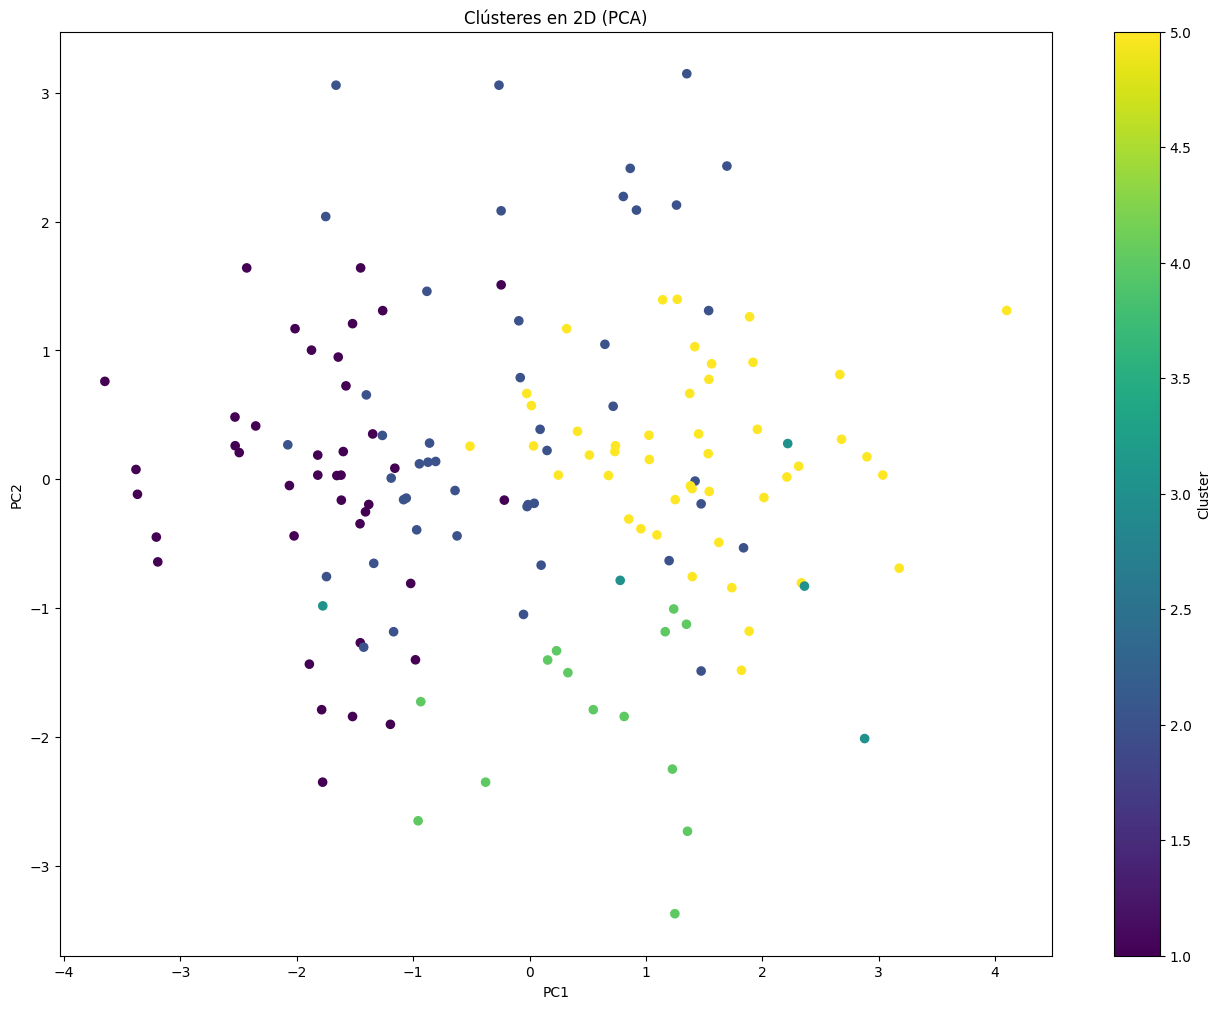

In [52]:
# Paso 4: Visualización 2D con PCA y varianza explicada
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_scaled)

var_total = pca.explained_variance_ratio_.sum() * 100
print(f"Varianza explicada (PC1+PC2): {var_total:.2f}%")

plt.figure(figsize=(16, 12))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=data["Cluster"], s=35)
plt.colorbar(label="Cluster")
plt.title("Clústeres en 2D (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


La visualización 2D se realizó con **PCA** para proyectar las 6 variables en dos componentes (PC1 y PC2). En el gráfico se observa una separación parcial entre grupos, aunque existe solapamiento en algunas zonas, lo cual es esperable al reducir dimensiones.

La varianza explicada por PC1+PC2 fue de **65.13%**, por lo que el plano representa una parte importante de la información, pero no toda. El porcentaje restante (**34.87%**) puede contener diferencias entre clústeres que no se ven en 2D, haciendo que algunos grupos parezcan mezclados aunque estén mejor separados en el espacio original.


---
## <font color='264CC7'> Métricas  </font>

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
Calcula la métrica de la silueta para los grupos obtenidos. ¿Qué tan buenos te parecen los grupos?
</div>

In [53]:
# Paso 5: Silhouette score

sil = silhouette_score(X_scaled, data["Cluster"], metric="euclidean")
print(f"Silhouette score: {sil:.4f}")


Silhouette score: 0.1674


El índice de silueta obtenido fue **0.1674**. Este valor es **bajo**, lo que indica que los clústeres no están completamente bien separados y existe solapamiento entre algunos grupos. Aun así, al ser positivo, sugiere que hay cierta estructura de agrupamiento, pero la calidad global de los grupos es **moderada/baja**.


---
## <font color='264CC7'> Iteraciones </font>

<div style="background-color: #edf1f8; border-color: #264CC7; border-left: 5px solid #264CC7; padding: 0.5em;">
<strong>Ejercicio:</strong><br>
    Realiza el proceso de agrupamiento jerárquico con diferentes parámetros, analiza la métrica de la silueta de cada uno e indica cuál es el mejor.
</div>

In [54]:
# Paso 6: Iteraciones

metodos = ["single", "complete", "average", "ward"]
ks = range(2, 11)

resultados = []
for m in metodos:
    Zm = linkage(X_scaled, method=m, metric="euclidean")
    for k in ks:
        labels = fcluster(Zm, t=k, criterion="maxclust")
        n_clusters = len(np.unique(labels))
        tamaños = pd.Series(labels).value_counts()
        sil = np.nan if tamaños.min() < 2 else silhouette_score(X_scaled, labels, metric="euclidean")
        resultados.append({"metodo": m, "k": k, "clusters_reales": n_clusters, "silueta": sil})

df_res = pd.DataFrame(resultados).sort_values("silueta", ascending=False)
display(df_res.head(10))

mejor = df_res.dropna().iloc[0]
print(f"Mejor configuración: método={mejor['metodo']}, k={int(mejor['k'])}, silueta={mejor['silueta']:.4f}")


,metodo,k,clusters_reales,silueta
27,ward,2,2,0.247504
28,ward,3,3,0.229665
30,ward,5,5,0.223737
9,complete,2,2,0.215277
10,complete,3,3,0.213349
29,ward,4,4,0.210735
11,complete,4,4,0.197342
32,ward,7,7,0.176823
13,complete,6,6,0.176340
31,ward,6,6,0.168703


Mejor configuración: método=ward, k=2, silueta=0.2475


Se probaron varios parámetros del agrupamiento jerárquico (métodos de enlace y distintos valores de k) y se comparó el **índice de silueta** de cada configuración.

La mejor configuración fue **Ward con k = 2**, con un **silhouette score = 0.2475**, que fue el valor más alto obtenido. Esto sugiere que, para estos datos, separar en **2 grupos** usando Ward produce la partición más coherente (mejor cohesión interna y mayor separación entre grupos) en comparación con las demás combinaciones evaluadas.


---
## <font color='264CC7'> Extra </font>

In [55]:
# Configuración extra

X = data[numeric_cols].values
X_scaled = RobustScaler().fit_transform(X)

Z = linkage(X_scaled, method="complete", metric="cosine")
data["Cluster_best"] = fcluster(Z, t=2, criterion="maxclust")

sil = silhouette_score(X_scaled, data["Cluster_best"], metric="cosine")
print(f"Silhouette : {sil:.4f}")


Silhouette : 0.4845


Para mejorar la calidad de los clústeres se probaron distintas combinaciones de escalado, métrica y enlace. La mejor configuración fue **RobustScaler + métrica cosine + enlace complete**, con **k = 2**, obteniendo un **silhouette score = 0.4845** (muy superior al obtenido con euclidiana). Esto sugiere que en estos datos es más útil comparar el “perfil” de estadísticas (cosine) y usar un escalado robusto para reducir el efecto de valores extremos.
